In [12]:
import pickle
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_style("darkgrid")
# sns.set_context("paper")
sns.set_context("talk")

In [13]:
def font_setting():
    # Set the font dictionaries (for plot title and axis titles)
    title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'bold',
                'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'weight': 'bold'}
    return title_font, axis_font


In [14]:
with open('../../results/reg_results_mlp.P', 'rb') as f:
    mlp_results = pickle.load(f)

with open('../../results/reg_results_rnn.P', 'rb') as f:
    rnn_results = pickle.load(f)


In [15]:
reg_results_mlp =  mlp_results['reg_results']
reg_results_rnn =  rnn_results['reg_results']

runs, checkpoints, ncoef:  20 21 3


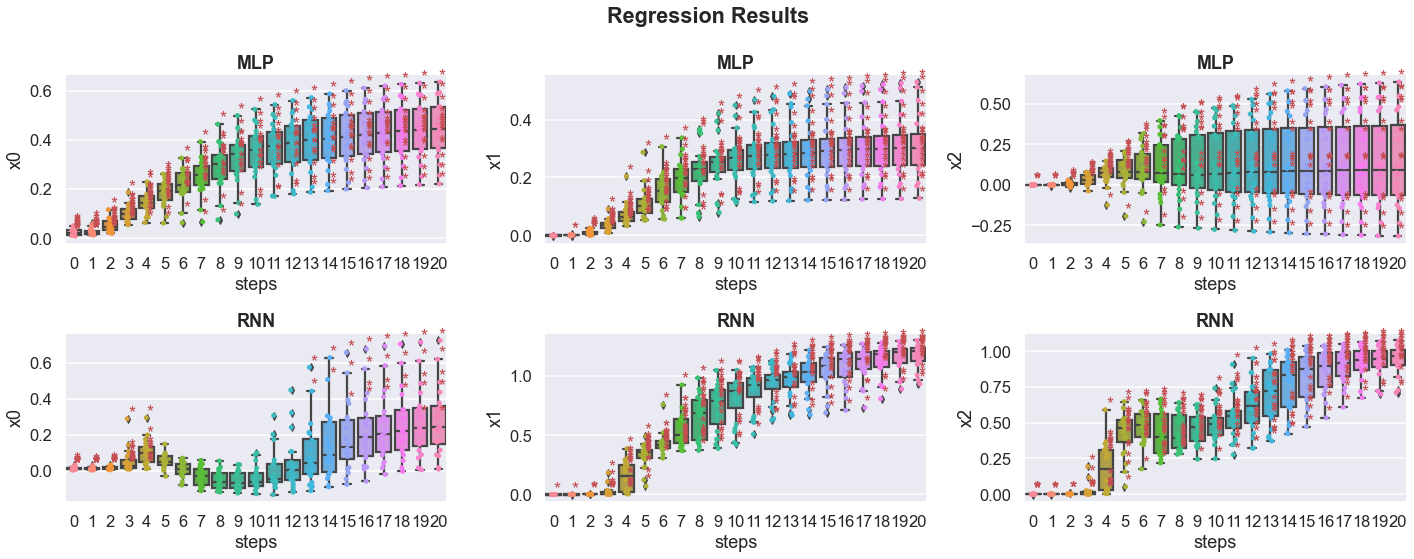

In [16]:
# categorical
# MLP
cat_regs = reg_results_mlp['cat_regs']
param_mlp = cat_regs['params']
p_val_mlp = cat_regs['p_vals']
# RNN
cat_regs = reg_results_rnn['cat_regs']
param_rnn = cat_regs['params']
p_val_rnn = cat_regs['p_vals']

runs = param_mlp.shape[0]
checkpoints = param_mlp.shape[1]
ncoef = param_mlp.shape[2]
print('runs, checkpoints, ncoef: ', runs, checkpoints, ncoef)

fig, axs = plt.subplots(2, ncoef, figsize=(20,8))
# title_font, _ = font_setting()
# sns.set()
for coef in range(ncoef):
    val_name = 'x%s' %(coef)
    # MLP
    val = param_mlp[:,:,coef]
    df = pd.DataFrame(val, columns= np.arange(checkpoints))
    df.insert(0, 'runs', np.arange(runs))
    df2 = pd.melt(df, id_vars=['runs'],var_name='steps', value_name=val_name)
    # plot
    ax = axs[0][coef]
    ax = sns.boxplot(x='steps', y=val_name, data=df2, ax=ax)
    ax = sns.stripplot(x='steps', y=val_name, data=df2, ax=ax)
    for run in range(runs):
        for i, p in enumerate(p_val_mlp[run,:,coef]):
            s = '*' if p<0.05 else ' '
            ax.annotate(s, (i, param_mlp[run, i, coef]), color='r')
    ax.set_title('MLP', fontweight='bold')
    
    # RNN
    val = param_rnn[:,:,coef]
    df = pd.DataFrame(val, columns= np.arange(checkpoints))
    df.insert(0, 'runs', np.arange(runs))
    df2 = pd.melt(df, id_vars=['runs'],var_name='steps', value_name=val_name)
    # plot
    ax = axs[1][coef]
    ax = sns.boxplot(x='steps', y=val_name, data=df2, ax=ax)
    ax = sns.stripplot(x='steps', y=val_name, data=df2, ax=ax)
    for run in range(runs):
        for i, p in enumerate(p_val_rnn[run,:,coef]):
            s = '*' if p<0.05 else ' '
            ax.annotate(s, (i, param_rnn[run, i, coef]), color='r')
    ax.set_title('RNN', fontweight='bold')

fig_str = 'reg_results_both_models_hidds'

fig.suptitle('Regression Results', fontweight='bold')
plt.tight_layout()
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
            bbox_inches = 'tight', pad_inches = 0)